In [1]:
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer  # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re  # regular expressions, useful for decoding the output

In [2]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
    """(1 pt) Create a dataset of pairs of numbers to calculate an operation on.
    DO NOT USE A FOR LOOP. Use pytorch functions, possibilities include meshgrid, stack, reshape, repeat, tile.
    (Note you'll have to use for loops on string stuff in other functions)

    The dataset should be a tuple of two tensors, X and y, where X is a Nx2 tensor of numbers to add,
    and y is a N tensor of the correct answers.
    E.g., if i_start=0, i_end=2, then X should be tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).
    I recommend doing all pairs of sums involving 0-49, but you may modify this.
    """
    # TODO
    x1, x2 = t.meshgrid(t.arange(i_end), t.arange(i_end), indexing='ij')
    X = t.stack([x1.flatten(), x2.flatten()], dim=1).reshape(-1, 2)
    y = operation(X[:, 0], X[:, 1])
    return X, y

In [3]:
def load_LLM(default="EleutherAI/gpt-neo-1.3B", device='cpu'):
    """(1 pt) Load a pretrained LLM and put on device. Default choice is a large-ish GPT-neo-2.7B model on Huggingface.
    Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or others
    here: https://huggingface.co/models?pipeline_tag=text-generation
    Explicitly load model and tokenizer, don't use the huggingface "pipeline" which hides details of the model
    (and it also has no batch processing, which we need here)
    """
    # TODO
    model = AutoModelForCausalLM.from_pretrained(default).to(device)
    tokenizer = AutoTokenizer.from_pretrained(default)
    return model, tokenizer

In [4]:
def encode_problems(X, strategy='baseline'):
    """(1 pts) Encode the problems as strings. For example, if X is [[0,0,1,1],[0,1,0,1]],
    then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]"""
    output_strings = []
    for xi in X:
        if strategy == 'baseline':
            # TODO: encode_string =
            encode_string = f"{xi[0]}+{xi[1]}="
        else:
            # TODO: encode_string = f"add numbers {xi[0]} and {xi[1]}"
            encode_string = f"If A={xi[0]}, and B={xi[1]}, then A+B="
        output_strings.append(encode_string)
    return output_strings

In [5]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'):
    """(3 pts) Complete the prompt using the LLM.
    1. Tokenize the prompts: https://huggingface.co/docs/transformers/preprocessing
        Put data and model on device to speed up computations
        (Note that in real life, you'd use a dataloader to do this efficiently in the background during training.)

    2. Generate text using the model.
        Turn off gradient tracking to save memory.
        Determine the sampling hyper-parameters.
        You may need to do it in batches, depending on memory constraints

    3. Use the tokenizer to decode the output.
    You will need to optionally print out the tokenization of the input and output strings for use in the write-up.
    """
    t0 = time.time()
    # TODO: tokenize
    # TODO: generate text, turn off gradient tracking
    # TODO: decode output, output_strings = ...
    # TODO: tokenize
    batch_size = 32
    max_length = 32

    # Tokenize
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    inputs = tokenizer.batch_encode_plus(prompts, max_length=max_length, padding=True, truncation=True, return_tensors="pt")

    # Turn off gradient tracking to save memory
    with t.no_grad():
    # Generate text in batches using the model
        output_ids = []
        for i in range(0, len(inputs['input_ids']), batch_size):
            batch_inputs = {k:v[i:i+batch_size].to(device) for k,v in inputs.items()}
            output = model.generate(input_ids=batch_inputs['input_ids'], attention_mask=batch_inputs['attention_mask'], 
                                    max_length=max_length, do_sample=True,temperature=0.1, 
                                    repetition_penalty= 1.5, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
            # Convert output tensors to list of lists of integers  top_p= 0.95, top_k=13, 
            # output_ints = [[int(token) for token in tensor] for tensor in output]
            output_ids.append(output)
    
    # Concatenate the generated output ids into a single tensor
    output_ids = t.cat(output_ids, dim=0)

    # Decode the output using the tokenizer
    output_strings = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    # [tokenizer.batch_decode(ints, skip_special_tokens=True) for ints in output_ids]


    if verbose:
        # TODO: print example tokenization for write-up
        for i in range(5):
            print(f"Input: {prompts[i]}")
            print(f"Tokenized Input: {tokenizer.encode(prompts[i])}")
            print(f"Output: {output_strings[i]}")
            print(f"Tokenized output: {tokenizer.encode(output_strings[i])}")
    print("Time to generate text: ", time.time() - t0, "\n")  # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.
    return output_strings

In [6]:
def decode_output(output_strings, strategy='baseline', verbose=True):
    """(1 pt) Decode the output strings into a list of integers. Use "t.nan" for failed responses.
    One suggestion is to split on non-numeric characters, then convert to int. And use try/except to catch errors.
    """
    y_hat = []
    for s in output_strings:
        # TODO: y = f(s)
        try:
            y = sum(map(int, re.findall(r'\d+', s)))        
        except:            
            y = np.nan
        y_hat.append(y)
    return y_hat

In [7]:
def analyze_results(X, y, y_hats, strategies):
    """(3 pts) Analyze the results.
    Output the accuracy of each strategy.
    Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
    and different plot markers to indicate whether the answer from your LLM was correct.
    (See write-up instructions for requirements on plots)
    Train a classifier to predict whether the LLM gave the correct response (using scikit-learn, for example)
    and plot the classifier boundary over the scatter plot with “contour”. (Use whatever classifier looks appropriate)"""
    # TODO
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    # Compute accuracy for each strategy
    accs = [accuracy_score(y, y_hat) for y_hat in y_hats]
    equal = []
    for i, acc in enumerate(accs):
        y_hat = y_hats[i]
        print(f"Accuracy for strategy {strategies[i]}: {acc:.4f}")
        is_same = np.equal(y, y_hat)
        equal.append(is_same)
    
    # Create scatter plot with markers indicating correct/incorrect answers
    fig, axes = plt.subplots(1, len(strategies), figsize=(5*len(strategies), 5))
    for i, ax in enumerate(axes):
        colors = ['b' if same else 'y' for same in equal[i]]
        ax.scatter(X[:,0], X[:,1], c=colors, marker='x')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title('Scatter plot for '+ str(strategies[i])+ ' strategies')
        ax.legend(handles=[plt.Line2D([], [], marker='x', color='b', label='Correct'),
                            plt.Line2D([], [], marker='x', color='y', label='Incorrect')],
                  loc='upper left')
        ax.grid(True)    
    plt.show()

    y = y.numpy()
    # Create scatter plot with markers indicating correct/incorrect answers
    fig, axes = plt.subplots(1, len(strategies), figsize=(5*len(strategies), 5))
    for i, ax in enumerate(axes):
        y_hat = np.array(y_hats[i])
        classes = np.where(y == y_hat, 1, -1)
        clf = DecisionTreeClassifier()
        clf.fit(X, classes)
        yhat = clf.predict(X)
        # evaluate the predictions
        acc = accuracy_score(classes, yhat)
        print(f'Accuracy using DecisionTreeClassifier for strategy {strategies[i]}: %.4f' % acc)
        xx, yy = np.meshgrid(np.arange(0.5, 49, 0.1), np.arange(0.5, 49, 0.1))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X[:,0], X[:,1], c=classes, cmap=plt.cm.coolwarm)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title('Contour plot for '+ str(strategies[i])+ ' strategies')
        ax.legend(handles=[plt.Line2D([], [], color='r', label='Correct'),
                            plt.Line2D([], [], color='b', label='Incorrect')],
                  loc='upper left')
        ax.grid(True)    
    plt.show()

Input: 0+0=
Tokenized Input: [15, 10, 15, 28]
Output: 0+0=0+0=0+0=0+0=0+0=0+0=0+0=0+0=
Tokenized output: [15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28, 15, 10, 15, 28]
Input: 0+1=
Tokenized Input: [15, 10, 16, 28]
Output: 0+1=0$ and $2\leq i\leq n-1$.

We now consider the case where $n=3
Tokenized output: [15, 10, 16, 28, 15, 3, 290, 720, 17, 59, 293, 80, 1312, 59, 293, 80, 299, 12, 16, 35307, 198, 198, 1135, 783, 2074, 262, 1339, 810, 720, 77, 28, 18]
Input: 0+2=
Tokenized Input: [15, 10, 17, 28]
Output: 0+2=0$ and $1+2=1$.

The following lemma is a direct consequence of the definition of the $q$
Tokenized output: [15, 10, 17, 28, 15, 3, 290, 720, 16, 10, 17, 28, 16, 35307, 198, 198, 464, 1708, 443, 21672, 318, 257, 1277, 12921, 286, 262, 6770, 286, 262, 720, 80, 3]
Input: 0+3=
Tokenized Input: [15, 10, 18, 28]
Output: 0+3=2\cdot 3+1=6$

A:

Hint:
$$\begin{align}
(
Tokenized output: [15, 10, 18, 28, 17, 59, 10210, 313, 

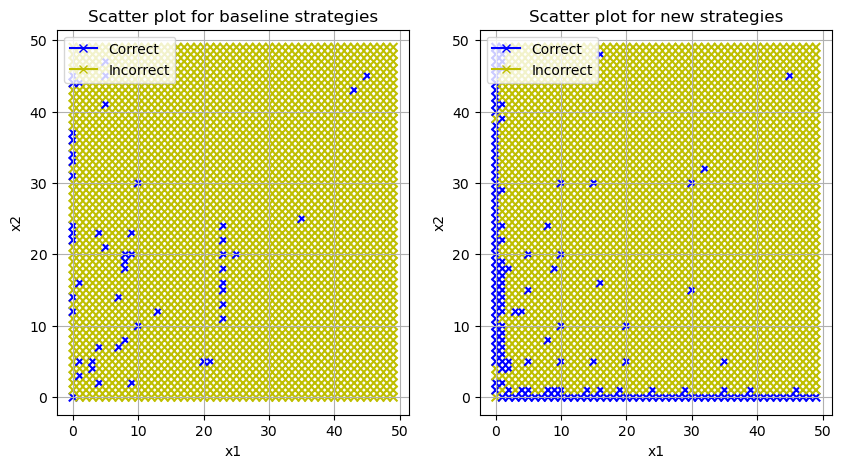

Accuracy using DecisionTreeClassifier for strategy baseline: 1.0000
Accuracy using DecisionTreeClassifier for strategy new: 1.0000


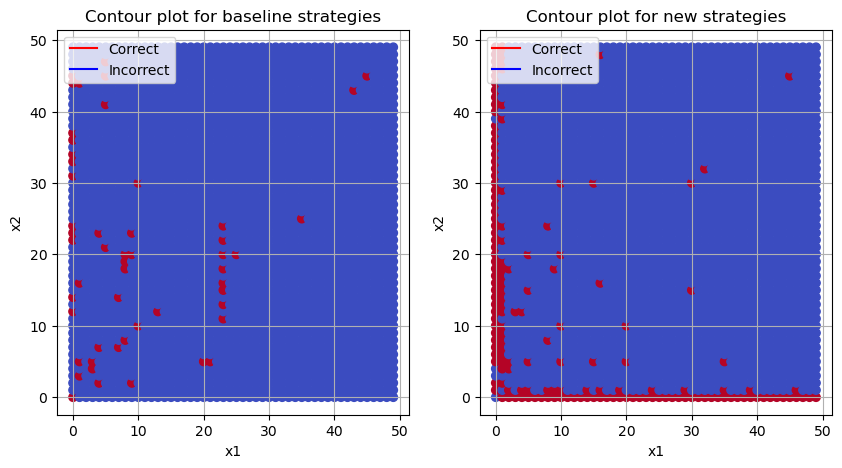

In [8]:
if __name__ == "__main__":
    device = t.device("cuda" if t.cuda.is_available() else "cpu")  # Use GPU if available
    device = t.device('mps') if t.backends.mps.is_available() else device  # Use Apple's Metal backend if available
    
    X, y = create_dataset(0, 50)
    model, tokenizer = load_LLM(device=device)

    y_hats = []  # list of lists of predicted answers, y_hat, for each strategy
    strategies = ['baseline', 'new']
    for strategy in strategies:
        input_strings = encode_problems(X, strategy=strategy)
        output_strings = generate_text(model, tokenizer, input_strings, device=device)
        output_strings = [out_s[len(in_s):] for in_s, out_s in zip(input_strings, output_strings)]  # Remove the input string from generated answer
        y_hats.append(decode_output(output_strings, strategy=strategy))

    analyze_results(X, y, y_hats, strategies)

In [9]:
def analyze_results1(X, y, y_hats, strategies):
    """(3 pts) Analyze the results.
    Output the accuracy of each strategy.
    Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
    and different plot markers to indicate whether the answer from your LLM was correct.
    (See write-up instructions for requirements on plots)
    Train a classifier to predict whether the LLM gave the correct response (using scikit-learn, for example)
    and plot the classifier boundary over the scatter plot with “contour”. (Use whatever classifier looks appropriate)"""
    # TODO
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    # Compute accuracy for each strategy
    accs = [accuracy_score(y, y_hat) for y_hat in y_hats]
    equal = []
    for i, acc in enumerate(accs):
        y_hat = y_hats[i]
        print(f"Accuracy for strategy {strategies[i]}: {acc:.4f}")
        is_same = np.equal(y, y_hat)
        equal.append(is_same)
    
    # Create scatter plot with markers indicating correct/incorrect answers
    fig, axes = plt.subplots(1, len(strategies), figsize=(5*len(strategies), 5))
    for i, ax in enumerate(axes):
        colors = ['b' if same else 'y' for same in equal[i]]
        ax.scatter(X[:,0], X[:,1], c=colors, marker='x')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title('Scatter plot for '+ str(strategies[i])+ ' strategies')
        ax.legend(handles=[plt.Line2D([], [], marker='x', color='b', label='Correct'),
                            plt.Line2D([], [], marker='x', color='y', label='Incorrect')],
                  loc='upper left')
        ax.grid(True)    
    plt.show()

    y = y.numpy()
    # Create scatter plot with markers indicating correct/incorrect answers
    fig, axes = plt.subplots(1, len(strategies), figsize=(5*len(strategies), 5))
    for i, ax in enumerate(axes):
        y_hat = np.array(y_hats[i])
        classes = np.where(y == y_hat, 1, -1)
        clf = DecisionTreeClassifier()
        clf.fit(X, classes)
        yhat = clf.predict(X)
        # evaluate the predictions
        acc = accuracy_score(classes, yhat)
        print(f'Accuracy using DecisionTreeClassifier for strategy {strategies[i]}: %.4f' % acc)
        xx, yy = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X[0:10,0], X[0:10,1], c=classes[0:10], cmap=plt.cm.coolwarm)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title('Contour plot for '+ str(strategies[i])+ ' strategies')
        ax.legend(handles=[plt.Line2D([], [], color='r', label='Correct'),
                            plt.Line2D([], [], color='b', label='Incorrect')],
                  loc='upper left')
        ax.grid(True)    
    plt.show()

Accuracy for strategy baseline: 0.0208
Accuracy for strategy new: 0.0640


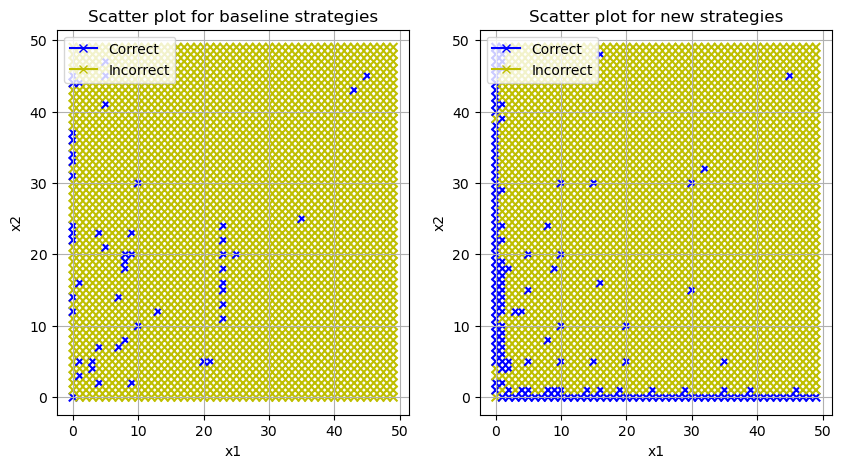

Accuracy using DecisionTreeClassifier for strategy baseline: 1.0000
Accuracy using DecisionTreeClassifier for strategy new: 1.0000


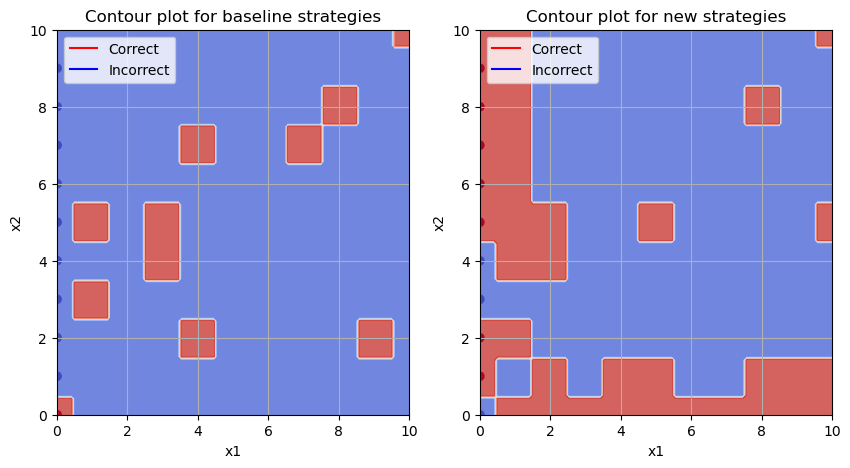

In [10]:
analyze_results1(X, y, y_hats, strategies)

## References:

1. [Summarization with Transformers: Settings for Success](https://www.sicara.fr/blog-technique/summarization-with-transformers-setting-up-for-success)
2. [Faster Text Generation with TensorFlow and XLA](https://github.com/huggingface/blog/blob/main/tf-xla-generate.md)
3. [Text generation using GPT-2](https://www.modeldifferently.com/en/2021/12/generación-de-fake-news-con-gpt-2/#1-introduction)